In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import emukit.test_functions

high_fidelity_ = emukit.test_functions.non_linear_sin.nonlinear_sin_high
low_fidelity_ = emukit.test_functions.non_linear_sin.nonlinear_sin_low

def filter(x): 
    return 10 * np.exp(-(x-0.5) ** 2 / 0.1)

def high_fidelity(x):
    return high_fidelity_(x) * filter(x)
def mid_fidelity(x):
    return filter(x) * low_fidelity_(x)
def low_fidelity(x):
    return low_fidelity_(x)

In [3]:
from mfGPR.mfGPR import mfGPR

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [4]:
np.random.seed(10**4)

In [5]:
N_low = 50
N_mid = 25
N_high = 12
noise_level = 0.05

In [6]:
x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

y_plot_m = mid_fidelity(x_plot)

x_train_l = np.atleast_2d(np.random.rand(N_low)).T
#x_train_l = np.atleast_2d(np.linspace(0,1,N_low)).T
x_train_m = np.atleast_2d(np.random.permutation(x_train_l)[:N_mid])
x_train_h = np.atleast_2d(np.random.permutation(x_train_m)[:N_high])

y_train_l = low_fidelity(x_train_l) + noise_level * np.random.normal(size=x_train_l.shape[0]).reshape(-1, 1)
y_train_h = high_fidelity(x_train_h)+ noise_level * np.random.normal(size=x_train_h.shape[0]).reshape(-1, 1)
y_train_m = mid_fidelity(x_train_m)+ noise_level * np.random.normal(size=x_train_m.shape[0]).reshape(-1, 1)




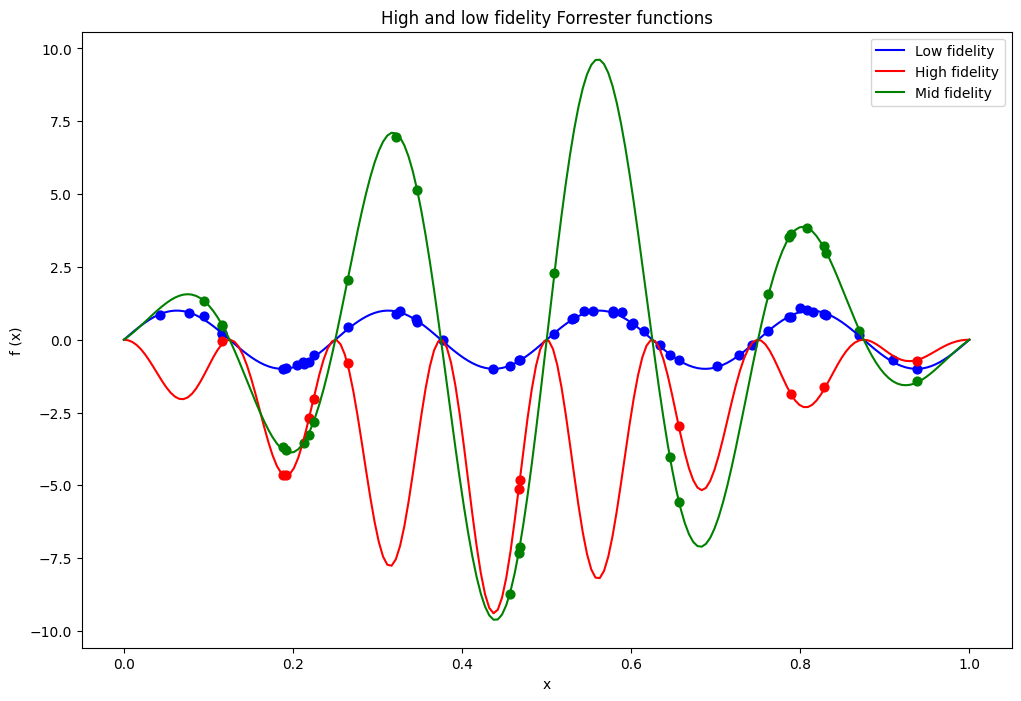

In [7]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, y_plot_m, 'g')
plt.scatter(x_train_l, y_train_l, color='b', s=40)
plt.scatter(x_train_h, y_train_h, color='r', s=40)
plt.scatter(x_train_m, y_train_m, color='g', s=40)
plt.ylabel('f (x)')
plt.xlabel('x')
plt.legend(['Low fidelity', 'High fidelity', 'Mid fidelity'])
plt.title('High and low fidelity Forrester functions');

In [8]:
data = {'low': {'data':[x_train_l, y_train_l]},
        'high_vanilla': {'data':[x_train_h, y_train_h]},#
        'mid': {'data':[x_train_m, y_train_m]},
        'high': {'data':[x_train_h, y_train_h], 'condition': ['low', 'mid'], 'theta':[0.5, 0.5]},
       }

In [9]:
data = {'low': {'data':[x_train_l, y_train_l]},
        'high_vanilla': {'data':[x_train_h, y_train_h]},
        'mid': {'data':[x_train_m, y_train_m], 'condition':'low'},
        'high': {'data':[x_train_h, y_train_h], 'condition': 'mid'},
       }

In [10]:
mfGPR_models = mfGPR(data=data, n_samples=500)

 /project2/andrewferguson/Kirill/env_mfGPR/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /project2/andrewferguson/Kirill/env_mfGPR/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [11]:
mean_low, std_low = mfGPR_models['low'].predict(x_plot)
mean_vanilla, std_vanilla = mfGPR_models['high_vanilla'].predict(x_plot)
mean_mid, std_mid = mfGPR_models['mid'].predict(x_plot)

In [12]:
mean_high, std_high = mfGPR_models['high'].predict(x_plot)

In [13]:
mfGPR_models['high'].model

GP_regression.,value,constraints,priors
sum.mul.scale_kernel_fidelity2.variance,18.65618221137818,+ve,
sum.mul.scale_kernel_fidelity2.lengthscale,5666.587497309427,+ve,
sum.mul.previous_fidelity_fidelity2.variance,1.0,+ve fixed,
sum.mul.previous_fidelity_fidelity2.lengthscale,6.949515739662237,+ve,
sum.bias_kernel_fidelity2.variance,1.184697838111506,+ve,
sum.bias_kernel_fidelity2.lengthscale,0.02909685085593678,+ve,
sum.fixed.variance,1.0,+ve fixed,
Gaussian_noise.variance,0.007768038084982046,+ve,


In [14]:
mfGPR_models['mid'].model

GP_regression.,value,constraints,priors
sum.mul.scale_kernel_fidelity2.variance,211.72908992676176,+ve,
sum.mul.scale_kernel_fidelity2.lengthscale,0.30852570850152633,+ve,
sum.mul.previous_fidelity_fidelity2.variance,1.0,+ve fixed,
sum.mul.previous_fidelity_fidelity2.lengthscale,4.170074003905791,+ve,
sum.bias_kernel_fidelity2.variance,0.0006126450402165149,+ve,
sum.bias_kernel_fidelity2.lengthscale,0.001480829204062285,+ve,
sum.fixed.variance,1.0,+ve fixed,
Gaussian_noise.variance,0.00016460278175851396,+ve,


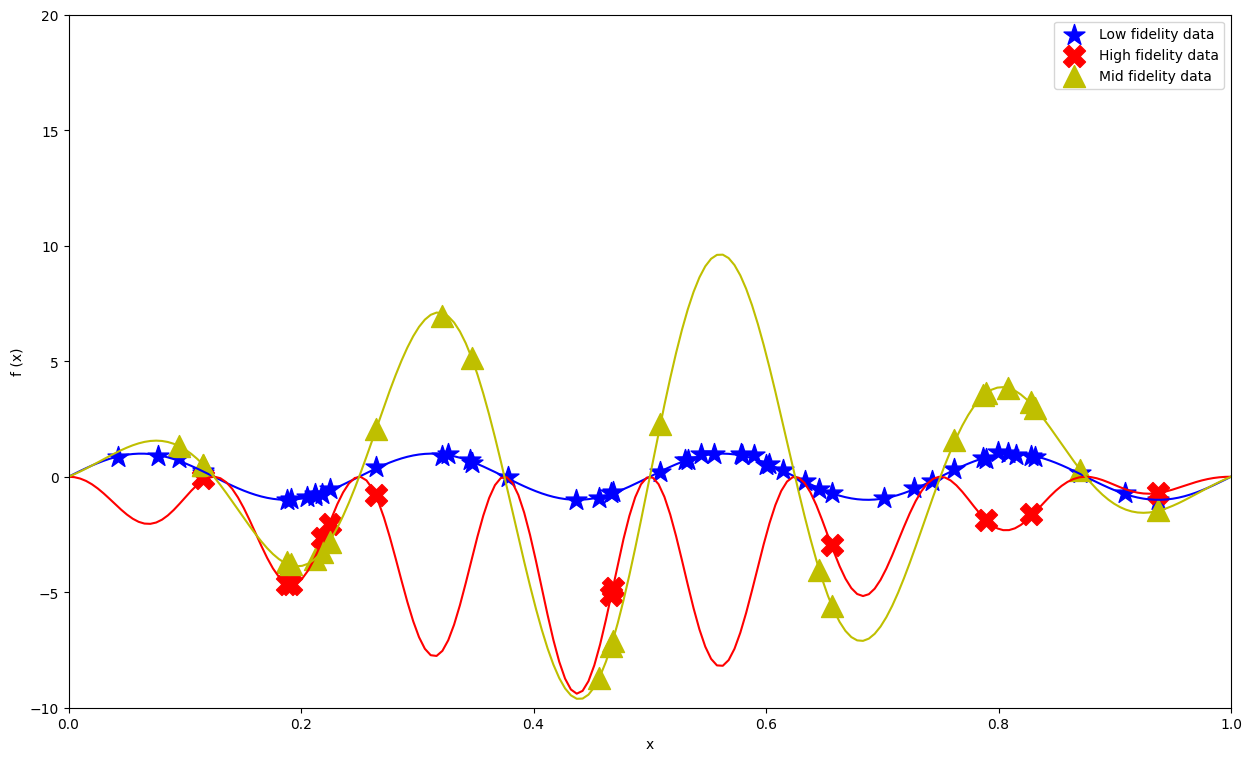

In [15]:
plt.figure(figsize=(15, 9))
#plt.fill_between(x_plot.flatten(), (mean_low - 1.96*std_low).flatten(), 
#                 (mean_low + 1.96*std_low).flatten(), facecolor='b', alpha=0.1)
#plt.fill_between(x_plot.flatten(), (mean_high - 1.96*std_high).flatten(), 
#                 (mean_high + 1.96*std_high).flatten(), facecolor='k', alpha=0.1)
#plt.fill_between(x_plot.flatten(), (mean_vanilla - 1.96*std_vanilla).flatten(), 
#                 (mean_vanilla + 1.96*std_vanilla).flatten(), facecolor='r', alpha=0.1)

plt.scatter(x_train_l, y_train_l, color='b', s=250, label='Low fidelity data', marker='*')
plt.scatter(x_train_h, y_train_h, color='r', s=250, label='High fidelity data', marker='X')
plt.scatter(x_train_m, y_train_m, color='y', s=250, label='Mid fidelity data', marker='^')

plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, y_plot_m, 'y')
#plt.plot(x_plot, mean_low, '--', color='b', label='Low fidelity fit')
#plt.plot(x_plot, mean_high, '--', color='k')
#plt.plot(x_plot, mean_vanilla, '--', color='r', label='High fidelity fit')
plt.ylabel('f (x)')
plt.xlabel('x')
plt.xlim(0,1)
plt.ylim(-10, 20)
#plt.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity', 'Predicted Vanilla'])
plt.legend()

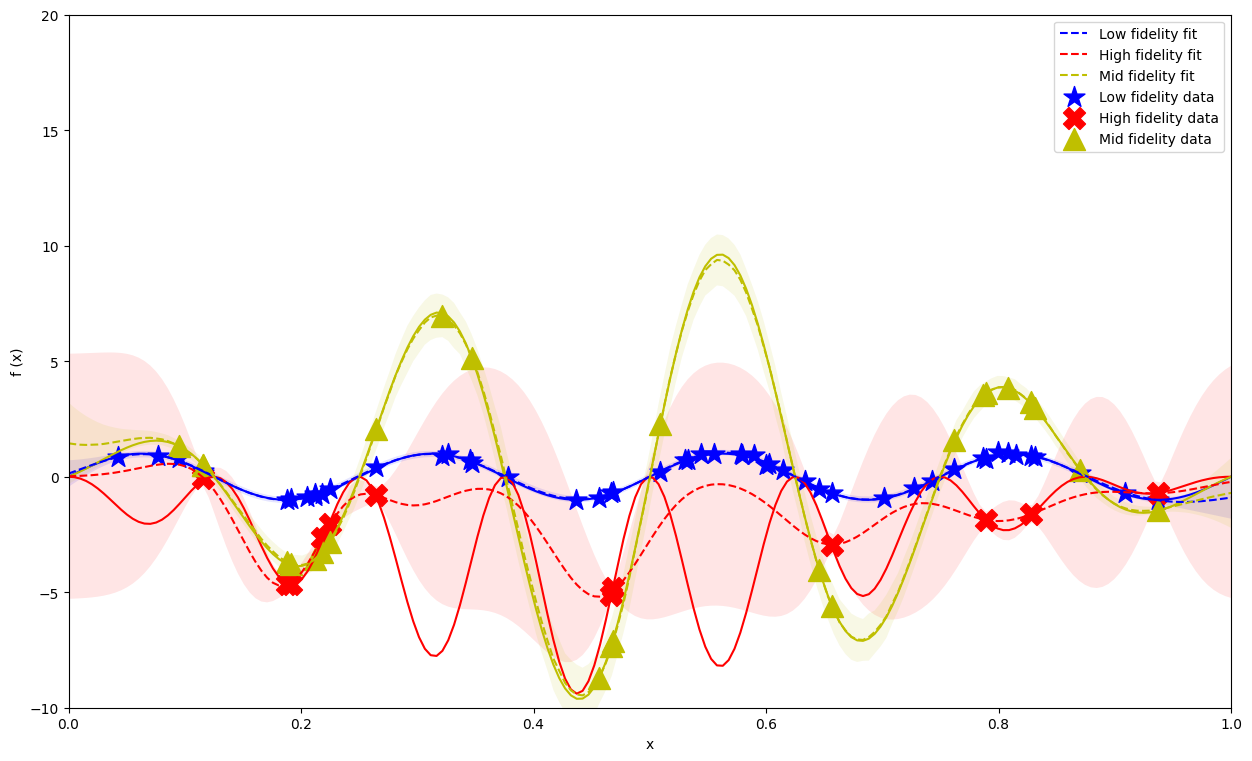

In [16]:
plt.figure(figsize=(15, 9))
plt.fill_between(x_plot.flatten(), (mean_low - 1.96*std_low).flatten(), 
                 (mean_low + 1.96*std_low).flatten(), facecolor='b', alpha=0.1)
#plt.fill_between(x_plot.flatten(), (mean_high - 1.96*std_high).flatten(), 
#                 (mean_high + 1.96*std_high).flatten(), facecolor='k', alpha=0.1)
plt.fill_between(x_plot.flatten(), (mean_vanilla - 1.96*std_vanilla).flatten(), 
                 (mean_vanilla + 1.96*std_vanilla).flatten(), facecolor='r', alpha=0.1)

plt.fill_between(x_plot.flatten(), (mean_mid - 1.96*std_mid).flatten(), 
                 (mean_mid + 1.96*std_mid).flatten(), facecolor='y', alpha=0.1)

plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, y_plot_m, 'y')
plt.plot(x_plot, mean_low, '--', color='b', label='Low fidelity fit')
#plt.plot(x_plot, mean_high, '--', color='k')
plt.plot(x_plot, mean_vanilla, '--', color='r', label='High fidelity fit')
plt.plot(x_plot, mean_mid, '--', color='y', label='Mid fidelity fit')
plt.scatter(x_train_l, y_train_l, color='b', s=250, label='Low fidelity data', marker='*')
plt.scatter(x_train_h, y_train_h, color='r', s=250, label='High fidelity data', marker='X')
plt.scatter(x_train_m, y_train_m, color='y', s=250, label='Mid fidelity data', marker='^')
plt.ylabel('f (x)')
plt.xlabel('x')
plt.xlim(0,1)
plt.ylim(-10, 20)
#plt.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity', 'Predicted Vanilla'])
plt.legend()

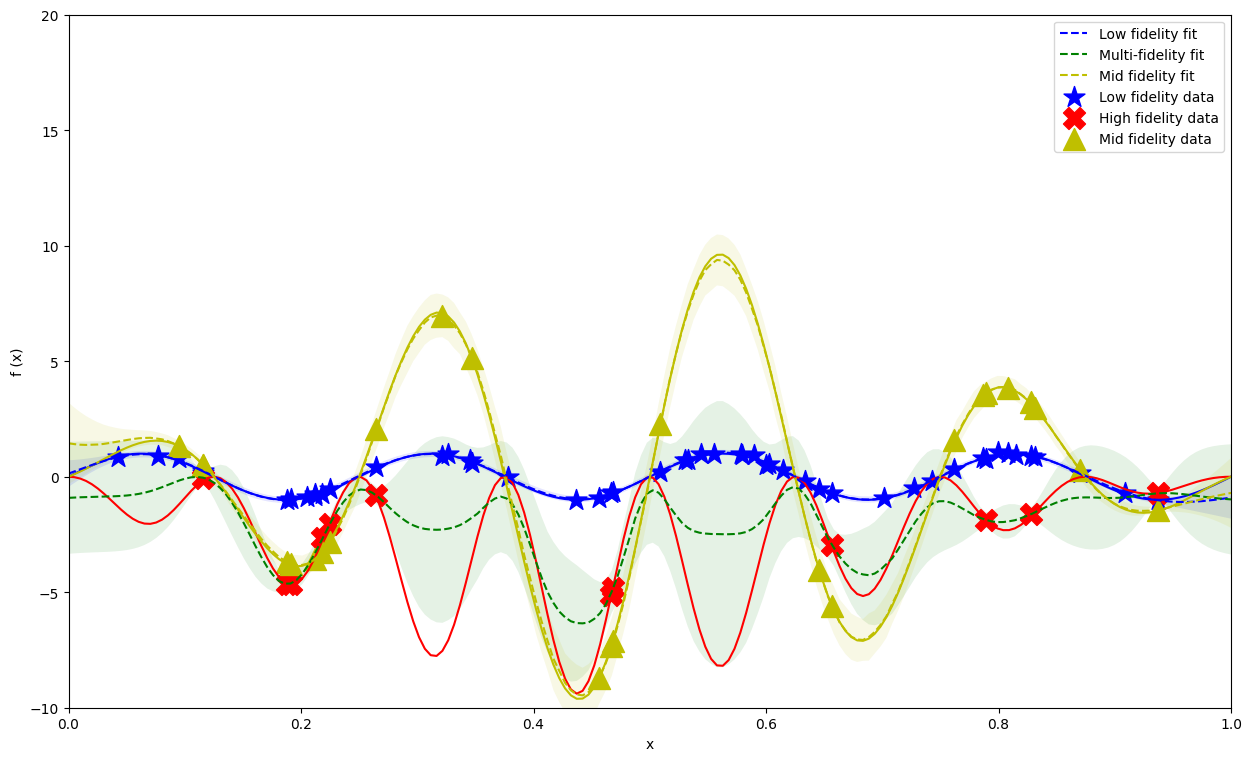

In [17]:
plt.figure(figsize=(15, 9))
plt.fill_between(x_plot.flatten(), (mean_low - 1.96*std_low).flatten(), 
                 (mean_low + 1.96*std_low).flatten(), facecolor='b', alpha=0.1)
plt.fill_between(x_plot.flatten(), (mean_high - 1.96*std_high).flatten(), 
                 (mean_high + 1.96*std_high).flatten(), facecolor='g', alpha=0.1)
#plt.fill_between(x_plot.flatten(), (mean_vanilla - 1.96*std_vanilla).flatten(), 
#                 (mean_vanilla + 1.96*std_vanilla).flatten(), facecolor='r', alpha=0.1)

plt.fill_between(x_plot.flatten(), (mean_mid - 1.96*std_mid).flatten(), 
                 (mean_mid + 1.96*std_mid).flatten(), facecolor='y', alpha=0.1)

plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, y_plot_m, 'y')
plt.plot(x_plot, mean_low, '--', color='b', label='Low fidelity fit')
#plt.plot(x_plot, mean_vanilla, '--', color='r', label='High fidelity fit')
plt.plot(x_plot, mean_high, '--', color='g', label='Multi-fidelity fit')
plt.plot(x_plot, mean_mid, '--', color='y', label='Mid fidelity fit')
plt.scatter(x_train_l, y_train_l, color='b', s=250, label='Low fidelity data', marker='*')
plt.scatter(x_train_h, y_train_h, color='r', s=250, label='High fidelity data', marker='X')
plt.scatter(x_train_m, y_train_m, color='y', s=250, label='Mid fidelity data', marker='^')

plt.ylabel('f (x)')
plt.xlabel('x')
plt.xlim(0,1)
plt.ylim(-10, 20)
#plt.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity', 'Predicted Vanilla'])
plt.legend()